## Goal: Check various hypothesis

In [186]:
import pandas as pd
import pypsa
prefix = "/mnt/c/Users/scl38887/Documents/git/aldehyde"

### Check 1: Compare with / without network

In [269]:
# Total system cost
runs = ["h2network_true", "h2network_false", "test_subworkflow"]

stats = pd.DataFrame(columns=runs, index=["H2", "AC", "total costs"])

for run in runs:
    metrics = pd.read_csv(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/csvs/metrics.csv", header=[0,1,2,3,4,5,6], index_col=0)
    prices = pd.read_csv(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/csvs/prices.csv", header=[0,1,2,3,4,5,6], index_col=0)

    stats.loc["H2", run] = prices.loc["H2"].values[0]
    stats.loc["AC", run] = prices.loc["AC"].values[0]
    stats.loc["total costs", run] = metrics.loc["total costs"].values[0]/1e9 # in B€


In [270]:
stats.head()

,h2network_true,h2network_false,test_subworkflow
H2,58.79,62.39,53.809
AC,46.937,47.61,41.976
total costs,18.785888,18.81631,8.511328


### Check 2: Hydrogen & battery storage

In [224]:
run = "h2network_true_3h"
export_only = prefix +"/resources/export_only/" + run +"/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved_einitial0.nc"
mar_only =prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_0export.nc"
mar_es_export =prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export.nc"
n = pypsa.Network(mar_es_export)

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [266]:
n_old = pypsa.Network(mar_es_export)
n_new = pypsa.Network(prefix +"/resources/export_only/" + run +"/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved.nc")

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


<AxesSubplot:xlabel='snapshot'>

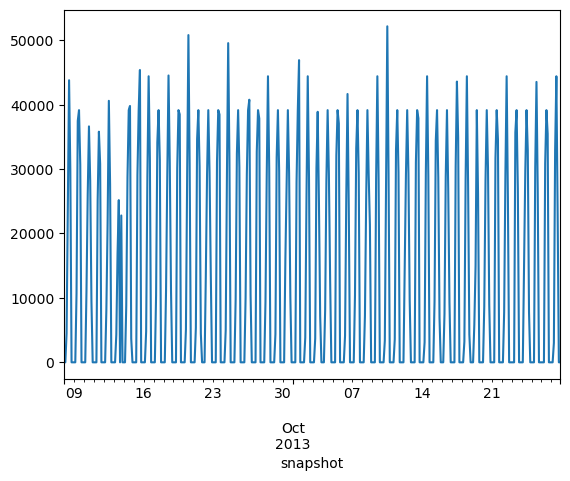

In [280]:
#export_supply_old[2000:2400].plot()
export_supply_new[2000:2400].plot()

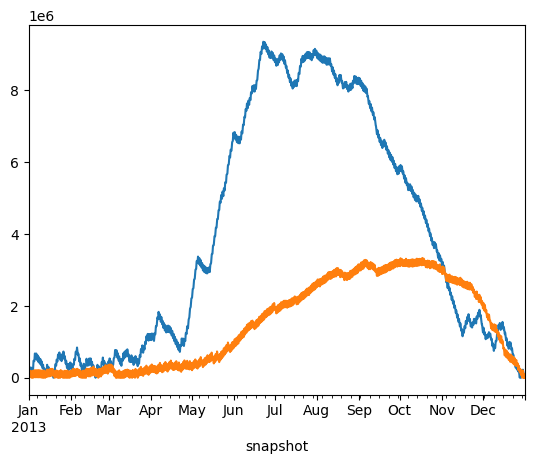

In [261]:
# Show storage levels and charging of 200 time steps
n_old.stores_t.e["H2 export store"].plot() #[2000:2200].plot()
n_new.stores_t.e["H2 export store"].plot() #[2000:2200].plot()

export_supply_new = (n_new.links_t.p1.loc[:, n_new.links_t.p1.columns.str.contains("export")].sum(axis=1)*(-1)) #.plot()


In [267]:
n_old.objective/1e6

17549.750889095947

In [268]:
n_new.objective/1e6

8062.726084512999

In [190]:
n.stores[(n.stores.carrier=="H2") & (n.stores.bus != "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh

162.06281206371472

In [191]:
n.stores[(n.stores.carrier=="battery")].e_nom_opt.sum() / 1e3 # in GWh

0.0

In [192]:
n.stores[n.stores.index.str.contains("battery")].head()

,bus,capital_cost,carrier,e_cyclic,e_nom_extendable,lifetime,marginal_cost,e_nom_opt,type,e_nom,...,e_min_pu,e_max_pu,e_initial,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,standing_loss,build_year
Store,,,,,,,,,,,,,,,,,,,,,
MA.1.1_1_AC battery,MA.1.1_1_AC battery,12295.064307,battery,True,True,25.0,0.009965,0.0,,0.0,...,0.0,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0
MA.1.2_1_AC battery,MA.1.2_1_AC battery,12295.064307,battery,True,True,25.0,0.009386,0.0,,0.0,...,0.0,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0
MA.1.3_1_AC battery,MA.1.3_1_AC battery,12295.064307,battery,True,True,25.0,0.009027,0.0,,0.0,...,0.0,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0
MA.10.1_1_AC battery,MA.10.1_1_AC battery,12295.064307,battery,True,True,25.0,0.010320,0.0,,0.0,...,0.0,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0
MA.10.3_1_AC battery,MA.10.3_1_AC battery,12295.064307,battery,True,True,25.0,0.010127,0.0,,0.0,...,0.0,1.0,0.0,False,True,0.0,0.0,1.0,0.0,0


In [193]:
n.generators.p_nom_opt.sort_values(ascending=False)[0:10]

Generator
MA.12.6_1_AC solar     101706.702944
MA.12.3_1_AC solar       5363.730691
MA.13.1_1_AC solar       3938.127924
MA.12.4_1_AC solar       3009.057499
MA.12.5_1_AC solar       2916.382887
MA.12.6_1_AC onwind      2218.263313
MA.8.2_1_AC solar        1218.987594
MA.8.1_1_AC solar         963.695392
MA.13.1_1_AC ror          464.000000
MA.12.5_1_AC onwind       126.334911
Name: p_nom_opt, dtype: float64

In [194]:
n.links_t.p0.loc[:, n.links.index.str.contains("battery")].sum().sort_values(ascending=False)[0:10] #.head()

Link
MA.12.6_1_AC H2 export            3.555741e+07
MA.2.1_1_AC H2 Electrolysis       4.090217e+06
MA.2.1_1_AC H2 export             2.781347e+06
MA.14.1_1_AC H2 Electrolysis      1.723098e+06
MA.14.1_1_AC H2 export            1.171707e+06
MA.14.3_1_AC H2 Electrolysis      6.780233e+05
MA.14.3_1_AC H2 export            4.610558e+05
MA.4.1_1_AC battery charger       0.000000e+00
MA.4.1_1_AC battery discharger    0.000000e+00
MA.8.1_1_AC H2 Electrolysis       0.000000e+00
dtype: float64

In [195]:
# Show capacities and nodes of top batteries
n.stores[(n.stores.carrier=="battery")].e_nom_opt.sort_values(ascending=False) # head()

Store
MA.1.1_1_AC battery     0.0
MA.5.2_1_AC battery     0.0
MA.15.3_1_AC battery    0.0
MA.2.1_1_AC battery     0.0
MA.2.2_1_AC battery     0.0
MA.3.2_1_AC battery     0.0
MA.3.3_1_AC battery     0.0
MA.3.4_1_AC battery     0.0
MA.4.1_1_AC battery     0.0
MA.4.2_1_AC battery     0.0
MA.5.1_1_AC battery     0.0
MA.6.3_1_AC battery     0.0
MA.15.1_1_AC battery    0.0
MA.8.1_1_AC battery     0.0
MA.8.2_1_AC battery     0.0
MA.8.3_1_AC battery     0.0
MA.8.4_1_AC battery     0.0
MA.8.5_1_AC battery     0.0
MA.9.1_1_AC battery     0.0
MA.9.2_1_AC battery     0.0
MA.9.3_1_AC battery     0.0
MA.9.4_1_AC battery     0.0
MA.15.2_1_AC battery    0.0
MA.14.5_1_AC battery    0.0
MA.1.2_1_AC battery     0.0
MA.12.2_1_AC battery    0.0
MA.1.3_1_AC battery     0.0
MA.10.1_1_AC battery    0.0
MA.10.3_1_AC battery    0.0
MA.10.4_1_AC battery    0.0
MA.10.5_1_AC battery    0.0
MA.11.1_1_AC battery    0.0
MA.11.3_1_AC battery    0.0
MA.11.4_1_AC battery    0.0
MA.12.1_1_AC battery    0.0
MA.12.3_1_AC b

Export hydrogen storage

In [223]:
n.stores[n.stores.bus == "H2 export bus"].e_nom_opt.sum() / 1e3 # in GWh

0.989375008491998

In [222]:
n.loads

,bus,carrier,p_set,type,q_set,sign
Load,,,,,,
MA.1.1_1_AC,MA.1.1_1_AC,AC,0.000000,,0.0,-1.0
MA.1.2_1_AC,MA.1.2_1_AC,AC,0.000000,,0.0,-1.0
MA.1.3_1_AC,MA.1.3_1_AC,AC,0.000000,,0.0,-1.0
MA.10.1_1_AC,MA.10.1_1_AC,AC,0.000000,,0.0,-1.0
MA.10.3_1_AC,MA.10.3_1_AC,AC,0.000000,,0.0,-1.0
...,...,...,...,...,...,...
MA.9.3_1_AC land transport oil,MA.9.3_1_AC oil,land transport oil,0.000000,,0.0,-1.0
MA.9.4_1_AC land transport oil,MA.9.4_1_AC oil,land transport oil,0.000000,,0.0,-1.0
MA.9.5_1_AC land transport oil,MA.9.5_1_AC oil,land transport oil,0.000000,,0.0,-1.0


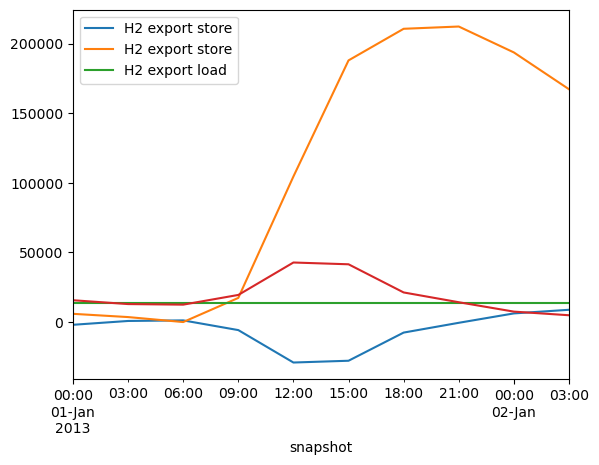

In [225]:
# Show storage levels and charging of 200 time steps
time_min = 0
time_max = 10
ax = n.stores_t.p["H2 export store"][time_min:time_max].plot()
n.stores_t.e["H2 export store"][time_min:time_max].plot()
n.loads_t.p["H2 export load"][time_min:time_max].plot()
export_supply = (n.links_t.p1.loc[:, n.links_t.p1.columns.str.contains("export")].sum(axis=1)[time_min:time_max]*(-1)) #.plot()
export_supply.plot()
ax.legend()

<AxesSubplot:xlabel='snapshot'>

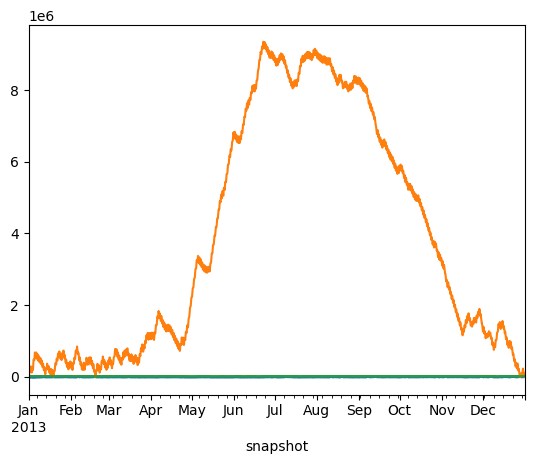

In [226]:
# Show storage levels and charging of 200 time steps
n.stores_t.p["H2 export store"].plot()
n.stores_t.e["H2 export store"].plot() #[2000:2200].plot()
n.loads_t.p["H2 export load"].plot()

Retrieve storage sizes of one type (MAR ES export) of various scenarios/runs

In [251]:
# Get storage sizes of hydrogen and battery for all networks
runs = ["store_nocosts_6h_ws", "store_standard_costs_6h_ws", "store_nostore_6h_ws"]

stats = pd.DataFrame(columns=runs, index=["H2_GWh", "Battery_GWh", "H2export_GWh"])

for run in runs:
    
    network_path = prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc"

    n = pypsa.Network(network_path)

    stats.loc["H2_GWh", run] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus != "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["Battery_GWh", run] = n.stores[(n.stores.carrier=="battery")].e_nom_opt.sum() / 1e3 # in GWh

    stats.loc["H2export_GWh", run] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus == "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved_einitial0.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Retrieve storage sizes across types (MAR ES only, MAR ES export, Export only) within one scenario/run

In [ ]:
# Get storage sizes of hydrogen and battery for all networks
run = "h2network_true_3h"
networks = ["export_only", "mar_only", "mar_es_export"]

network_paths = {
        "export_only": prefix +"/resources/export_only/" + run +"/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved.nc",
        "mar_only": prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_0export.nc",
        "mar_es_export": prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export.nc",
}


stats = pd.DataFrame(columns=networks, index=["H2_GWh", "Battery_GWh", "H2export_GWh"])

for network in networks:
    
    n = pypsa.Network(network_paths[network])

    stats.loc["H2_GWh", network] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus != "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["Battery_GWh", network] = n.stores[(n.stores.carrier=="battery")].e_nom_opt.sum() / 1e3 # in GWh

    stats.loc["H2export_GWh", network] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus == "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh



INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved_einitial0.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [252]:
stats.head()

,export_only,mar_only,mar_es_export
H2_GWh,162.062812,41.522685,45.991291
Battery_GWh,0.0,60.81319,57.954655
